In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

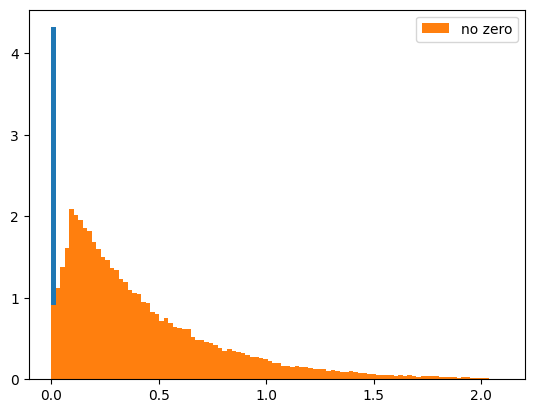

In [3]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

LED_times = (df['intended_fix'] - df['LED_onset_time']).values
plt.hist(LED_times, bins=100, density=True);

# remove zero from LED_times
LED_times = LED_times[LED_times != 0]
plt.hist(LED_times, bins=100, density=True, label='no zero');

plt.legend();


In [4]:
dt = 1e-4; dB = 1e-2

def proactive_V_A_change_simulate(base_V_A, theta_A, slope):
    DV = 0
    t = 0
    LED_onset_time = np.random.choice(LED_times)
    while True:
        if t <= LED_onset_time:
            v = base_V_A
        else:
            v = base_V_A + slope * (t - LED_onset_time)
        
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= theta_A:
            return t, LED_onset_time, ( base_V_A, theta_A, slope )

In [6]:
# ---- PARAMS  ---
base_V_A = 1
theta_A = 2
slope = 0.25

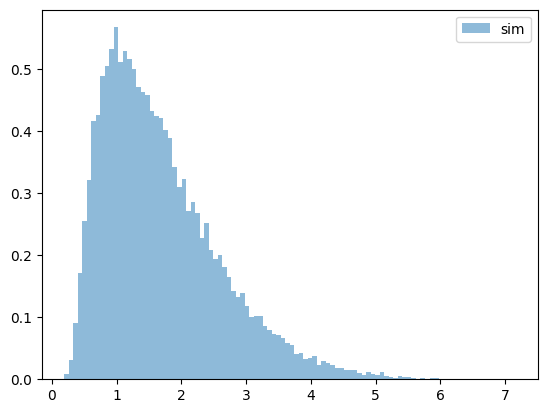

In [8]:
from joblib import Parallel, delayed
N_sim = int(25e3)
sim_results_1 = Parallel(n_jobs=-1)(delayed(proactive_V_A_change_simulate)(base_V_A, theta_A, slope) for _ in range(N_sim))
plt.hist([t for t, _, _ in sim_results_1], bins=100, density=True, alpha=0.5, label='sim')
plt.legend();

In [9]:
from matplotlib.pylab import f


led_times_1 = [led_time for _, led_time, _ in sim_results_1]

led_times_1_unique = np.unique(led_times_1)

print(f'len ofunique LED times: {len(led_times_1_unique)}')

len ofunique LED times: 20922


In [10]:
def proactive_V_A_change_simulate_2(base_V_A, theta_A, slope, LED_onset_time):
    DV = 0
    t = 0
    while True:
        if t <= LED_onset_time:
            v = base_V_A
        else:
            v = base_V_A + slope * (t - LED_onset_time)
        
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= theta_A:
            return t, LED_onset_time, ( base_V_A, theta_A, slope )

In [13]:
# sample 1000 led_times_1_unique
led_times_1_unique_sampled = np.random.choice(led_times_1_unique, 100)
len(led_times_1_unique_sampled)


100

In [15]:
bw = 0.05
bins = np.arange(0, 4, bw)

hist_var_led_times = np.zeros((len(led_times_1_unique_sampled), len(bins)-1))
from tqdm import tqdm
for i, led_time in tqdm(enumerate(led_times_1_unique_sampled), total=len(led_times_1_unique_sampled)):
    sim_results_2 = Parallel(n_jobs=-1)(delayed(proactive_V_A_change_simulate_2)(base_V_A, theta_A, slope, led_time) for _ in range(1000))
    hist_var_led_times[i, :], _ = np.histogram([t for t, _, _ in sim_results_2], bins=bins, density=True)


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


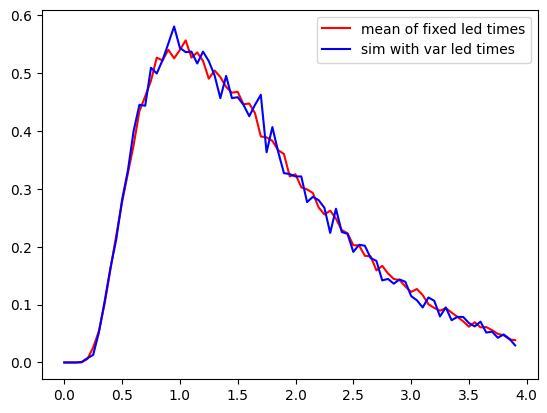

In [18]:
hist_var_led_mean = np.mean(hist_var_led_times, axis=0)

sim_results_1_times = [t for t, _, _ in sim_results_1]
hist_1 = np.histogram(sim_results_1_times, bins=bins, density=True)[0]

plt.plot(bins[:-1], hist_var_led_mean, label='mean of fixed led times', color='r')
plt.plot(bins[:-1], hist_1, label='sim with var led times', color='b');
plt.legend();